 <h1> Paraphrase Detection with Neural Networks - Natural Language Understanding </h1>


CSI4106 Artificial Intelligence Project <br/>
Prepared by Abha Sharma & Rupsi Kaushik

<h2> Background </h2>

With the growing trends of virtual assistants and chatbots, Natural Language Processing (NLP) is a topic that is becoming increasingly popular in the recent years. From Google AI's Transformer-based models that consider a word's double-sided context to IBM's training data generator, today we have cutting edge approaches to solving NLP tasks.  However, even with these latest breakthroughs, NLP still faces many challenges, namely the problem of accurately deciphering what humans mean when they express something, regardless of how they express it. This problem falls under Natural Language Understanding (NLU), a subtopic of NLP that aims to increase the proficiency of intelligent systems in exhibiting real knowledge of natural language. Within this field, the task of paraphrase detection - determining whether a pair of sentences convey identical meaning - is considered to be an important one. Through the improvement of paraphrase detection, other NLP tasks that are integral to the efficiency of existing intelligent systems, such as question answering, information retrieval, and text summarization, can also be improved. For this reason, in this report, we propose to enhance the capability of neural networks in the context of paraphrase detection through the use of traditional Information Retrieval (IR) techniques as input features. 


*add and edit as you want*

<h2> Objectives </h2>

The main objective of this report is to evaluate the performance of a neural network model given different IR features. Additionally, it will take a look at how the number of features and hidden layers improve the overall performance of the model. These results will be compared among two different training sets that have been annotated for paraphrase detection. Below is the proposed architecture for our particular neural network: 
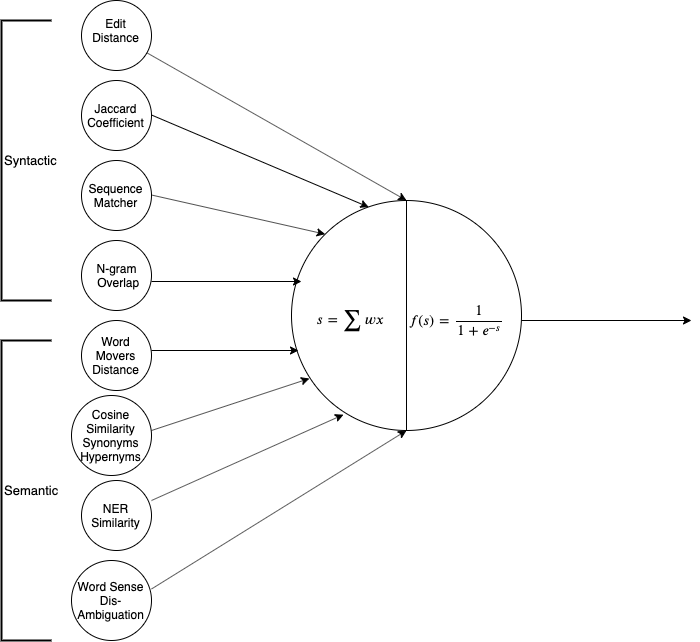

*adding the diagram & add and edit as you want* 

<h2> Datasets </h2>

We will be working with the Quora Question Pairs and Microsoft Research Paraphrase Corpus datasets for this project. You can find them in this folder labelled as 'msr_train.csv' and 'questions_train.csv'

In [ ]:
#Make sure to import all these modules
import pandas as pd
pd.options.mode.use_inf_as_na = True
from pyemd import emd
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.wsd import lesk
from nltk import ngrams
from difflib import SequenceMatcher
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
word_vectors = api.load("glove-wiki-gigaword-100")
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing
import tensorflow as tf 
from tensorflow import keras

In [ ]:
# Taking a look at the Quora Question Pairs dataset
quora_data = pd.read_csv("questions_train.csv", error_bad_lines=False)
quora_data.Sentence_1 = quora_data.Sentence_1.astype(str)
quora_data.Sentence_2 = quora_data.Sentence_2.astype(str)
quora_data = quora_data[:4000]
quora_data.is_Paraphrase = quora_data.is_Paraphrase.astype(int)
quora_data.head(20)

In [ ]:
#Taking a look at the Microsoft Research Paraphrase dataset 
mrp_data = pd.read_csv("msr_train.csv")
mrp_data.Sentence_1 = mrp_data.Sentence_1.astype(str)
mrp_data.Sentence_2 = mrp_data.Sentence_2.astype(str)
mrp_data.head(20)

<h2> Preprocessing & Transformation </h2>

In [ ]:
def remove_stop_words(sentence):
    stop_words = stopwords.words('english')
    processed_sentence = [word for word in sentence if not word in stop_words]
    return processed_sentence     
def tokenize(sentence):
    tokenized_sentence = sentence.lower().split()
    return tokenized_sentence
def lemmatize(sentence):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = [lemmatizer.lemmatize(word) for word in sentence]
    return lemmatized_sentence
def add_synonym(word):
    synonym_list = []
    for syn in wordnet.synsets(word):
        for name in syn.lemma_names():
             synonym_list.append(name.split(".")[0].replace('_',' '))
    return list(set(synonym_list))
def add_antonym(word):
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            if(lemma.antonyms()):
                return lemma.antonyms()[0].name()
            else:
                return None           
def add_hypernym(word):
    for syn in wordnet.synsets(word):
        for hypernym in syn.hypernyms():
            return hypernym.name().split('.')[0]
def tokenize_negation(sentence):
    negation_adverbs = ["no", "without","not", "n't", "never", "neith", "nor"]
    tokens_with_negation = []
    tokenized_sentence = tokenize(sentence)
    i = 0
    while i < (len(tokenized_sentence)):
        if (i != len(tokenized_sentence)-1) and (tokenized_sentence[i] in negation_adverbs):
            negation_token = add_antonym(tokenized_sentence[i+1])
            if(negation_token):
                tokens_with_negation.append(negation_token)
                i += 2 
            else:
                tokens_with_negation.append(tokenized_sentence[i])
                i +=1
        else:
            tokens_with_negation.append(tokenized_sentence[i])
            i += 1
    return tokens_with_negation

<h2>Feature Engineering</h2>

<h3>Syntactic Similarity</h3>

<h4>Edit Distance</h4>

*Explain Edit Distance* 

In [ ]:
def edit_distance(row):
    sentence_one_tokenize = tokenize(row['Sentence_1'])
    sentence_two_tokenize = tokenize(row['Sentence_2'])
    return nltk.edit_distance(sentence_one_tokenize, sentence_two_tokenize)

In [ ]:
#Applying Edit Distance to Quora sentence pairs 
quora_data['Edit_distance'] = quora_data.apply(edit_distance, axis=1)
quora_data.head(20)

In [ ]:
#Applying Edit Distance to MRP Corpus sentence pairs 
mrp_data['Edit_distance'] = mrp_data.apply(edit_distance, axis=1)
mrp_data.head(20)

<h4>Jaccard Similarity Coefficient</h4>

*Explain Jaccard - smoothing with 1* 

In [ ]:
def jaccard_sim_coefficient(row):
    sentence_one_tokenize = tokenize(row['Sentence_1'])
    sentence_two_tokenize = tokenize(row['Sentence_2'])
    intersection = 0
    for word_in_one in sentence_one_tokenize:
        for word_in_two in sentence_two_tokenize:
            if word_in_one == word_in_two:
                intersection += 1
    union = (len(sentence_one_tokenize) + len(sentence_two_tokenize) - intersection)
    smoothed_intersection = intersection + 1
    smoothed_union = union + (len(sentence_one_tokenize) + len(sentence_two_tokenize))
    return smoothed_intersection/smoothed_union

In [ ]:
#Applying Jaccard Similarity Coefficient to Quora sentence pairs 
quora_data['Jaccard_similarity'] = quora_data.apply(jaccard_sim_coefficient, axis=1)
quora_data.head(20)

In [ ]:
#Applying Jaccard Similarity Coefficient to MRP Corpus sentence pairs 
mrp_data['Jaccard_similarity'] = mrp_data.apply(jaccard_sim_coefficient, axis=1)
mrp_data.head(20)

<h4>Sequence Matcher</h4>

*Explain Sequence Matcher*

In [ ]:
def sequence_matcher(row):
    return SequenceMatcher(None, row['Sentence_1'], row['Sentence_2']).ratio()

In [ ]:
#Applying Sequence Matcher to Quora sentence pairs 
quora_data['Sequence_matcher'] = quora_data.apply(sequence_matcher, axis=1)
quora_data.head(20)

In [ ]:
#Applying Sequence Matcher to MRP Corpus sentence pairs 
mrp_data['Sequence_matcher'] = mrp_data.apply(sequence_matcher, axis=1)
mrp_data.head(20)

<h4>N-gram measure</h4>

*Explain N-gram measure, n=3*

In [ ]:
def ngram_measure(row):
    n = 3
    common_count = 1
    grams_sentence_one = ngrams(row['Sentence_1'].split(), n)
    grams_sentence_two = ngrams(row['Sentence_2'].split(), n)
    grams_sentence_one_total = sum(1 for x in grams_sentence_one)
    grams_sentence_two_total = sum(1 for x in grams_sentence_two)
    for gram_in_one in grams_sentence_one:
        if gram_in_one in grams_sentence_two:
            common_count += 1
    return common_count / (grams_sentence_one_total + grams_sentence_two_total - common_count + grams_sentence_one_total + grams_sentence_two_total)

In [ ]:
#Applying N-gram Measure to Quora sentence pairs 
quora_data['N-gram_measure'] = quora_data.apply(ngram_measure, axis=1)
quora_data.head(20)

In [ ]:
#Applying N-gram Measure to MRP Corpus sentence pairs 
mrp_data['N-gram_measure'] = mrp_data.apply(ngram_measure, axis=1)
mrp_data.head(20)

<h4> Pairwise Cosine Similarity </h4>

*Explain*

In [ ]:
def get_cosine_similarity(row):
    sentence_one_tokenize = tokenize_negation(row['Sentence_1'])
    sentence_two_tokenize = tokenize_negation(row['Sentence_2'])
    filtered_sentence_one = remove_stop_words(sentence_one_tokenize)
    filtered_sentence_two = remove_stop_words(sentence_two_tokenize)
    #lemmatize to get the root words 
    lemmatize_sentence_one = lemmatize(filtered_sentence_one)
    lemmatize_sentence_two = lemmatize(filtered_sentence_two)
    return calculate_cosine_similarity(lemmatize_sentence_one, lemmatize_sentence_two)
def calculate_cosine_similarity(sentence_one, sentence_two):
    tfidf = TfidfVectorizer(preprocessor=' '.join)
    tfidf_matrix = tfidf.fit_transform([sentence_one, sentence_two])
    similarity = cosine_similarity(tfidf_matrix)[0,1]
    return similarity

In [ ]:
#Applying Cosine Similaritye to Quora sentence pairs 
quora_data['Cosine_Similarity'] = quora_data.apply(get_cosine_similarity, axis=1)
quora_data.head(20)

In [ ]:
#Applying Cosine Similarity to MRP Corpus sentence pairs 
mrp_data['Cosine_Similarity'] = mrp_data.apply(get_cosine_similarity, axis=1)
mrp_data.head(20)

<h3>Semantic Similarity</h3>

<h4> Word Mover's Distance </h4>


*Explain WMD here*

In [ ]:
def word_movers_distance(row):
    sentence_one_tokenize = tokenize(row['Sentence_1'])
    sentence_two_tokenize = tokenize(row['Sentence_2'])
    filtered_sentence_one = remove_stop_words(sentence_one_tokenize)
    filtered_sentence_two = remove_stop_words(sentence_two_tokenize)
    distance = word_vectors.wmdistance(filtered_sentence_one, filtered_sentence_two)
    return distance

In [ ]:
#Applying Word Mover's Distance to Quora sentence pairs 
quora_data['WMD_distance'] = quora_data.apply(word_movers_distance, axis=1)
quora_data.head(20)

In [ ]:
#Applying Word Mover's Distance to MRP Corpus sentence pairs 
mrp_data['WMD_distance'] = mrp_data.apply(word_movers_distance, axis=1)
mrp_data.head(20)

<h4>Named Entity Recognition Similarity</h4>

*Explain NER with jaccard*

In [ ]:
def ner_measure(row):
    ner_sentence_one=[]
    ner_sentence_two=[]
    count_common_ner = 0
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(row['Sentence_1']))):
        if hasattr(chunk, 'label'):
            ner_sentence_one.append(chunk)
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(row['Sentence_2']))):
        if hasattr(chunk, 'label'):
            ner_sentence_two.append(chunk)
    for item in ner_sentence_one:
        if item in ner_sentence_two:
            count_common_ner += 1
    smoothed_intersection = count_common_ner + 1
    union = len(ner_sentence_one) + len(ner_sentence_two) - count_common_ner
    smoothed_union = union + len(ner_sentence_one) + len(ner_sentence_two)
    # smoothed union set as 1 if both sentences have no NER
    if smoothed_union == 0:
        smoothed_union = 1
    return smoothed_intersection / smoothed_union

In [ ]:
#Applying NER Measure to Quora sentence pairs 
quora_data['NER_similarity'] = quora_data.apply(ner_measure, axis=1)
quora_data.head(20)

In [ ]:
#Applying NER Measure to MRP Corpus sentence pairs 
mrp_data['NER_similarity'] = mrp_data.apply(ner_measure, axis=1)
mrp_data.head(20)

<h4>Word Sense Disambiguation</h4>

*Explain WSD using Lesk algorithm*

In [ ]:
def wsd(row):
    sentence_one_senses = []
    sentence_two_senses = []
    common_senses = 0
    sentence_one_tokenize = tokenize(row['Sentence_1'])
    sentence_two_tokenize = tokenize(row['Sentence_2'])
    for word in sentence_one_tokenize:
        sentence_one_senses.append(lesk(row['Sentence_1'], word))
    for word in sentence_two_tokenize:
        sentence_two_senses.append(lesk(['Sentenece_2'], word))
    sentence_one_senses = (set(sentence_one_senses))
    sentence_two_senses = (set(sentence_two_senses))

    for sense in sentence_one_senses:
        if sense in sentence_two_senses:
            common_senses += 1
    return common_senses / (len(sentence_one_senses) + len(sentence_two_senses) - common_senses)

In [ ]:
#Applying WSD Measure to Quora sentence pairs 
quora_data['WSD'] = quora_data.apply(wsd, axis=1)
quora_data.head(20)

In [ ]:
#Applying WSD Measure to MRP Corpus sentence pairs 
mrp_data['WSD'] = mrp_data.apply(wsd, axis=1)
mrp_data.head(20)

<h4> Synonym Extended Cosine Similarity </h4>
Here, we will use WordNet's capabilities to extend our dictionary. We will then call our existing calculate_cosine_similarity method to get the similarity of the extended documents. 

In [ ]:
def extend_sentence_wordnet(row):
    sentence_one_tokenize = tokenize_negation(row['Sentence_1'])
    sentence_two_tokenize = tokenize_negation(row['Sentence_2'])
    filtered_sentence_one = remove_stop_words(sentence_one_tokenize)
    filtered_sentence_two = remove_stop_words(sentence_two_tokenize)
    #lemmatize to get the root words 
    lemmatize_sentence_one = lemmatize(filtered_sentence_one)
    lemmatize_sentence_two = lemmatize(filtered_sentence_two)
    # get extended synonym list    
    extended_dictionary_one = []
    extended_dictionary_two = []
    for one, two in zip(lemmatize_sentence_one, lemmatize_sentence_two):
        synonym_one = add_synonym(one)
        synonym_two = add_synonym(two)
        hypernym_one = add_hypernym(one)
        hypernym_two = add_hypernym(two)
        if(synonym_one):
            extended_dictionary_one += synonym_one
        if(hypernym_one):
            extended_dictionary_one += hypernym_one
        if(synonym_two):
            extended_dictionary_two += synonym_two
        if(hypernym_two):
            extended_dictionary_two += hypernym_two
    lemmatize_sentence_one += extended_dictionary_one
    lemmatize_sentence_two += extended_dictionary_two
    
    #calculate similarity based on the extended list 
    similarity = calculate_cosine_similarity(lemmatize_sentence_one, lemmatize_sentence_two)
    return similarity

In [ ]:
#Applying Synonym_Cosine to Quora sentence pairs 
quora_data['Synonym_Hypernym_Cosine'] = quora_data.apply(extend_sentence_wordnet, axis=1)
quora_data.head(20)

In [ ]:
mrp_data['Synonym_Hypernym_Cosine'] = mrp_data.apply(extend_sentence_wordnet, axis = 1)
mrp_data.head(20)

<h4> Hypernym Extended Similarity </h4>
Checking if words are near by in hypernym hierarchy  <br/>
Wordnet hierarchy augmented with probabilities  <br />
Then calculate shortest path based on similarity


<h2> Train Set & Test Set </h2>

For training with less bias, we want to maintain a reasonably equal class distribution. We want to make sure that we have a balanced class of non-paraphrase, as well as paraphrase pairs of sentences. If this is not possible, as with most real-life scenarios, we need to think of a way to adjust our metric for evaluation in order to accomodate for this imbalance. 

In [ ]:
print("Mrp Data:\n{}".format(mrp_data['is_Paraphrase'].value_counts()))
print("Quora Data:\n{}".format(quora_data['is_Paraphrase'].value_counts()))

<h2> Measures </h2>

In [ ]:
def calculate_accuracy(model, actual_tags):
    correct = 0
    total = 0
    for prediction, actual in zip(model, actual_tags):
        total += 1
        if prediction == actual:
            correct += 1 
    accuracy = correct / total 
    return '{0:.1%}'.format(accuracy)
def build_confusion_matrix(actual_tags, model, classOfInterest):
    confusion_matrix = {}
    truePositives = len([p for p, a in zip(model, actual_tags) if p == a and p == classOfInterest])
    trueNegatives = len([p for p, a in zip(model, actual_tags) if p == a and p != classOfInterest])
    falsePositives = len([p for p, a in zip(model, actual_tags) if p != a and p == classOfInterest])
    falseNegatives = len([p for p, a in zip(model, actual_tags) if p != a and p != classOfInterest])
    confusion_matrix["tp"] = truePositives
    confusion_matrix["tn"] = trueNegatives
    confusion_matrix["fp"] = falsePositives 
    confusion_matrix["fn"] = falseNegatives
    return confusion_matrix
def calculate_recall(model, actual_tags, classOfInterest):
    matrix = build_confusion_matrix(model, actual_tags, classOfInterest)
    recall = matrix["tp"] / ( matrix["tp"] + matrix ["fn"])
    return '{0:.1%}'.format(recall)
def calculate_precision(model, actual_tags, classOfInterest):
    matrix = build_confusion_matrix(model, actual_tags, classOfInterest)
    precision = matrix["tp"]/ (matrix["tp"] + matrix["fp"])
    return '{0:.1%}'.format(precision)

<h2> Model </h2>

<h3> Baseline Model </h3>

Firstly, instead of randomly picking a threshold for the baseline method, we are going to 'learn' a threshold that yields best results for us in terms of accuracy, recall, and precision. 

In [ ]:
def learn_threshold(row, **kwargs):
    if(row['Cosine_Similarity'] > kwargs['threshold']):
        classification = 1
    else:
        classification = 0
    return classification

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
quora_data_thresholds = {}
mrp_data_thresholds = {}
accuracies = {}
recalls = {}
precisions = {}
for threshold in thresholds:
    quora_data_thresholds[threshold] = quora_data.apply(learn_threshold, threshold = threshold, axis = 1)
    accuracies[threshold] = calculate_accuracy(quora_data_thresholds[threshold], quora_data['is_Paraphrase'])
    recalls[threshold] = calculate_recall(quora_data_thresholds[threshold], quora_data['is_Paraphrase'], 1)
    precisions[threshold] = calculate_precision(quora_data_thresholds[threshold], quora_data['is_Paraphrase'], 1)
print("Quora Accuracy: {}, \n Quora Recall: {},\nQuora Precision: {}" .format(accuracies, recalls, precisions))

for threshold in thresholds:
    mrp_data_thresholds[threshold] = mrp_data.apply(learn_threshold, threshold = threshold, axis = 1)
    accuracies[threshold] = calculate_accuracy(mrp_data_thresholds[threshold], mrp_data['is_Paraphrase'])
    recalls[threshold] = calculate_recall(mrp_data_thresholds[threshold], mrp_data['is_Paraphrase'],1)
    precisions[threshold] = calculate_precision(mrp_data_thresholds[threshold], mrp_data['is_Paraphrase'], 1)
print("MRP Accuracy: {}, \nMRP Recall: {},\nMRP Precision: {}" .format(accuracies, recalls, precisions))

In [ ]:
def apply_cosine_classification(row):
    if (row['Cosine_Similarity'] > 0.5):
        classification = 1
    else:
        classification = 0
    return classification

In [ ]:
quora_baseline = {}
quora_baseline['Cosine_Classification'] = quora_data.apply(apply_cosine_classification, axis=1)
print(quora_baseline)

In [ ]:
mrp_baseline = {}
mrp_baseline['Cosine_Classification'] = mrp_data.apply(apply_cosine_classification, axis=1)
print(mrp_baseline)

<h3> Post Process </h3>

*Explain*

In [ ]:
max_quora = quora_data.loc[quora_data['WMD_distance'] != np.nan, 'WMD_distance'].max()
quora_data['WMD_distance'].replace(np.nan, max_quora, inplace=True)
x = quora_data[['WMD_distance']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
quora_data['WMD_distance'] = pd.DataFrame(x_scaled)


max_microsoft = mrp_data.loc[mrp_data['WMD_distance'] != np.nan, 'WMD_distance'].max()
mrp_data['WMD_distance'].replace(np.nan, max_microsoft, inplace=True)
y = mrp_data[['WMD_distance']].values.astype(float)
min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(y)
mrp_data['WMD_distance'] = pd.DataFrame(y_scaled)

<h3> Multi-layer Perceptron </h3>

In [ ]:
def multilayer_perceptron(df):
    properties = list(df.columns.values)
    properties.remove('is_Paraphrase')
    properties.remove('Sentence_1')
    properties.remove('Sentence_2')
    # properties.remove('NER_similarity')
    X = df[properties]
    y = df['is_Paraphrase']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    model = keras.Sequential([
    keras.layers.Flatten(input_shape=(9,)),
    keras.layers.Dense(7, activation=tf.nn.relu),
    keras.layers.Dense(7, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid),
    ])

    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

    model.fit(X_train, y_train, epochs=15, batch_size=1)

    test_loss, test_acc, test_pre, test_recall = model.evaluate(X_test, y_test)
    print('Test accuracy:{}, test recall: {}, test precision: {}'.format(test_acc, test_recall, test_pre))

In [ ]:
print("Multi-Layer Perceptron Results for quora_data")
multilayer_perceptron(quora_data)
print("\n*********************************************************************************\n")
print("Multi-Layer Perceptron Results for mrp_data")
multilayer_perceptron(mrp_data)

<h2> Results & Evaluation </h2>

In [ ]:
def baseline_evaluation_summary(baseline, df):
    baseline_accuracy = calculate_accuracy(baseline['Cosine_Classification'], df['is_Paraphrase'])
    baseline_recall = calculate_recall(baseline['Cosine_Classification'], df['is_Paraphrase'], 1)
    baseline_precision = calculate_precision(baseline['Cosine_Classification'], df['is_Paraphrase'], 1)
    
    baseline_evaluation_summary = {"Model": ['Baseline'],
                   "Accuracy":[(baseline_accuracy)], 
                   "Recall":[baseline_recall], 
                   "Precision":[baseline_precision]}
    results_df = pd.DataFrame(baseline_evaluation_summary)
    print(results_df)

In [ ]:
baseline_evaluation_summary(quora_baseline, quora_data)
baseline_evaluation_summary(mrp_baseline, mrp_data)

<h2> Conclusion </h2>

We hypothesized that syntactic and semantic similarity were both important while predicting if a pair of sentences were paraphrase. We built our features based on this hypothesis, creating both syntactic and semantic features. 

<h2> References </h2>